In [1]:
import numpy as np
import pandas as pd
import string
import seaborn as sns
import altair as alt
import regex as re
alt.__version__

import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 16, 8
%matplotlib inline

import IPython; IPython.__version__
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [2]:
raw_data = pd.read_excel(r'./raw_data.xlsx', 'Sheet1')

Description des données : 
     
  - **titre**: titre de l'enquête souhaitée
  - **corps**: justification de la demande souhaitée (cf. titre)
  - **nombre de commentaires**: nombre de commentaires généré pour chaque requête
  - **nombre de soutiens**: nombre de soutiens généré pour chaque requête
  - **nombre d'abonnement**: nombre d'abonnements généré pour chaque requête
  - **catégorie**: classification de la requête
  - **...colonnes suivantes**: commentaires générés pour chaque requête

In [3]:
raw_data.head(4)

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires_associés_à_la_proposition,unnamed:_7,unnamed:_8,unnamed:_9,...,unnamed:_110,unnamed:_111,unnamed:_112,unnamed:_113,unnamed:_114,unnamed:_115,unnamed:_116,unnamed:_117,unnamed:_118,unnamed:_119
0,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Je partage ce point et ici on ne parle que d'u...,Préservons la mer qui loin de toute surveillan...,Que l'on arrête de nous mentir !! La protectio...,La protection des océans doit être notre prior...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Les citoyen ont le droit de savoir. Ces obsta...,"Quand on a rien à se reprocher, on a rien à ca...",Honte absolue de l'administration qui refuse d...,Et on s’étonne que le citoyen n’ai plus confia...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,L'argent public destiné aux fédérations de cha...,"Chaque année en France, des millions d'euros d...",114,1164,271,"Environnement, agriculture et mer",La chasse est un pseudo loisir consistant à tu...,"Pour préserver la faune sauvage, mieux vaut do...",Il est essentiel de contrôler l'usage qui est ...,Activité de « loisirs » consistant à tuer des ...,...,Pourquoi ne pas financer les dealeur.,"Si les chasseurs ""limitaient"" les populations ...",Je n’ai absolument aucun avis sur le sujet mai...,Pardon mais je cherche encore le moindre rappo...,"En France, la chasse + le balltrap c'est entre...",Il est intolérable que l'argent public finance...,J'ai déjà publié plusieurs commentaires sur ce...,"SUITE : . Mais les soi-disant ""premiers écolog...",", des agents des parcs nationaux, de l'ONF, ma...","Plus étonnant encore, l'Etat a aussi concouru ..."
3,Un nouveau contrôle des subventions aux éoliennes,"Sous prétexte de sauver la planète, le vent de...",69,660,142,Énergie,Parfaitement d'accord avec ce qui est dit. En ...,"C’est trop moche ; certes, la beauté est peut-...",Les subventions à la filière éolienne rendent...,"C'est ce que je croyais aussi, mais je confirm...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# transformation de la structure du dataframe 
## pivot des commentaires 
mod_data = (raw_data.set_index(['titre', 'corps', 'nombre_de_commentaires', 'nombre_de_soutiens', "nombre_abonnements", 'categorie'])
   .rename_axis(['drop'], axis=1)
   .stack()
   .reset_index())
mod_data = mod_data.drop(['drop'], axis=1)
mod_data = mod_data.rename(columns = {mod_data.columns[6]: "commentaires" })

## suppression des commentaires ayant comme texte "Pas de commentaies"
mod_data = mod_data[~mod_data['commentaires'].str.endswith('commentaires')]

In [5]:
# description du dataset
def description(df):
    print(f"Dataset Shape: {df.shape}") #check numbers of rows and columns 
    summary = pd.DataFrame(df.dtypes,columns = ['dtypes'])
    summary = summary.reset_index()
    summary['Name'] = summary['index']
    summary = summary[['Name','dtypes']] # data types
    summary['Valeurs manquantes'] = df.isnull().sum().values 
    summary['Valeurs uniques'] = df.nunique().values 
    summary['Première valeur'] = df.iloc[0].values 
    summary['Seconde valeur'] = df.iloc[1].values 
    summary['Troisième valeur'] = df.iloc[2].values 
    return summary

In [6]:
description(mod_data)

Dataset Shape: (1261, 7)


,Name,dtypes,Valeurs manquantes,Valeurs uniques,Première valeur,Seconde valeur,Troisième valeur
0,titre,object,0,161,Enquêter sur les moyens humains et financiers ...,Enquêter sur les moyens humains et financiers ...,Enquêter sur les moyens humains et financiers ...
1,corps,object,0,161,À l’heure du réchauffement climatique débridé ...,À l’heure du réchauffement climatique débridé ...,À l’heure du réchauffement climatique débridé ...
2,nombre_de_commentaires,int64,0,29,97,97,97
3,nombre_de_soutiens,int64,0,65,1825,1825,1825
4,nombre_abonnements,int64,0,37,260,260,260
5,categorie,object,0,18,"Environnement, agriculture et mer","Environnement, agriculture et mer","Environnement, agriculture et mer"
6,commentaires,object,0,1246,Je partage ce point et ici on ne parle que d'u...,Préservons la mer qui loin de toute surveillan...,Que l'on arrête de nous mentir !! La protectio...


In [7]:
mod_data['categorie'].value_counts()

Finances publiques & fiscalité                               361
Environnement, agriculture et mer                            250
Transports                                                   133
Énergie                                                       88
Non catégorisée                                               74
Sécurité sociale                                              61
Cohésion sociale, intégration et lutte contre l’exclusion     52
Économie & entreprises                                        42
Enseignement scolaire                                         40
Culture & communication                                       38
Famille                                                       35
Handicap & dépendance                                         25
Santé                                                         19
Enseignement supérieur & recherche                            15
Justice                                                       13
Emploi & formation profes

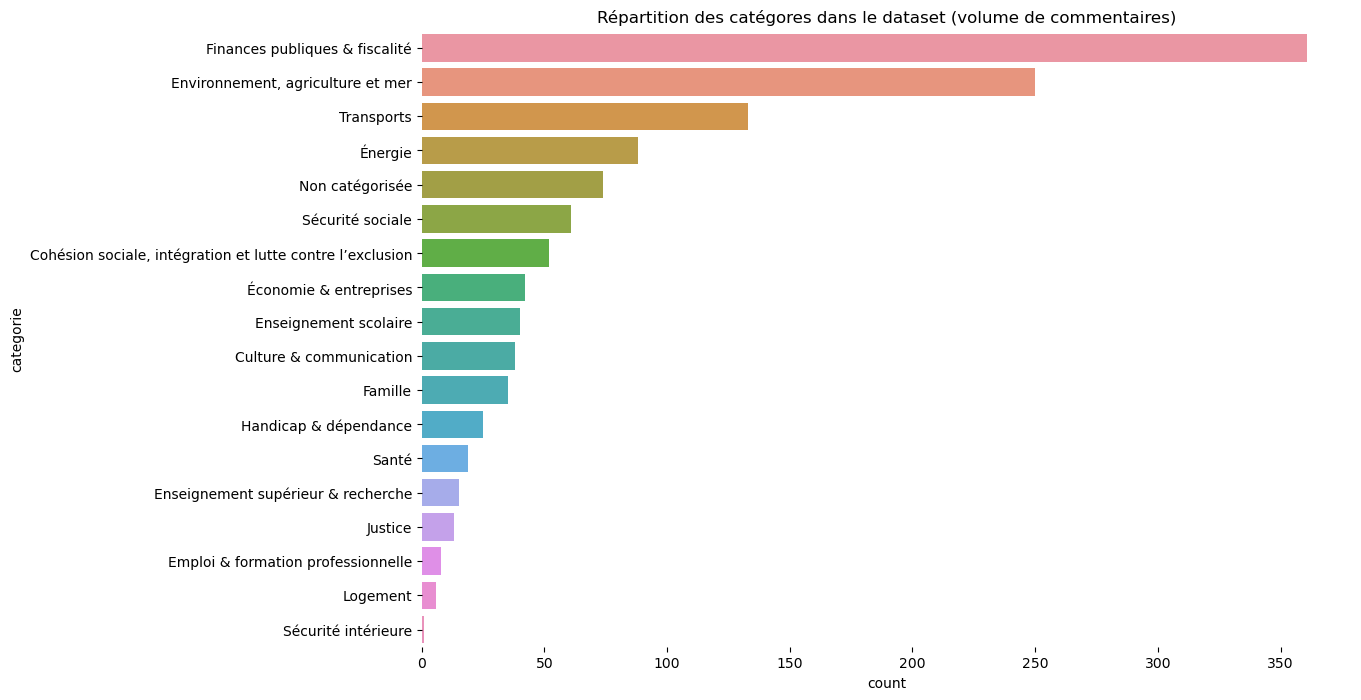

In [8]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,8))
plt.title("Répartition des catégores dans le dataset (volume de commentaires)")
sns.countplot(data = mod_data, y = 'categorie',
              order = mod_data['categorie'].value_counts().index, linewidth = None,
                   edgecolor = None)
sns.color_palette("tab10")
plt.box(False)
plt.show()

 ## Creation de features sur les commentaires 

### librairies nlp et mots communs

In [16]:
##nlp
import warnings
warnings.filterwarnings(action = 'ignore', category = UserWarning, module = 'gensim')
import gensim
import spacy
from spacy.lang.fr.stop_words import STOP_WORDS
import nltk
from nltk.tokenize import word_tokenize 
from nltk.tokenize import WordPunctTokenizer

In [17]:
print ('Importation du dictionnaire de stopwords SPACY')
nlp_fr = spacy.load('fr_core_news_sm')
print("Liste de stopwords français de SPACY a %d entrées" % len(nlp_fr.Defaults.stop_words))
print ('\n')
print ('Importation du dictionnaire perso')

custom_stop_words = []
with open( r'./dictionnaire_v13102021.txt', "r", encoding = 'utf8') as fin:
    for line in fin.readlines():
        custom_stop_words.append( line.strip() )
        
print("Liste de stopwords du dictionnaire perso a %d entrées" % len(custom_stop_words))
custom_stop_words_final = set(custom_stop_words)

print ('Importation du dictionnaire NLTK')
from nltk.corpus import stopwords
stopwords_fr = set(stopwords.words('french'))
print("Liste de stopwords de NLTK a %d entrées" % len(stopwords_fr))
custom = { 'ft','net', 'er', "ère", "est", "pas", 'sur'}
STOP_WORDS = nlp_fr.Defaults.stop_words.union(custom).union(stopwords_fr).union(custom_stop_words_final)

#ajout à la liste de mots communs
STOP_WORDS |= {'janvier', "monsieur", "cordialement", "madame", "fait", "faît","/"}

# suppression de la liste de mots communs
STOP_WORDS -= {"beaucoup","personnes", "personne", "pourrait", "rend", "serait", "sera"} 

print("Liste définitive de stopwords a %d entrées" % len(STOP_WORDS))

print("Liste finale des mots clés supprimés automatiquement")
print(sorted(STOP_WORDS))

Importation du dictionnaire de stopwords SPACY


ModuleNotFoundError: No module named 'google.protobuf'

### fonctions utilisées

In [19]:
# fonctions usuelles

## dénombre le nombre de mots
def word_count (text):
    x = re.sub(r'\s+', ' ', text)
    count = len(re.findall(r'\w+', x))
    return (count)

## calcule le pourcentage de texte en majuscule sur la base
## de l'ensemble du texte
def percentage(text):
    up = re.findall(r'[A-Z]', text)
    text = re.sub(r'\s+', ' ', text)#
    if len(up) == 0:
        percentage = 0
    else: 
        percentage = float(len(up)) / len(text)
    return percentage

## importation de la fonction punctuation de la librairie
punctuation = string.punctuation

### Calcul des features en lien avec les commentaires émis

In [20]:
mod_data['COUNTING_WORDS'] = mod_data['commentaires'].apply(lambda x: word_count(x))
mod_data['NB_CAR'] = mod_data['commentaires'].str.len()
mod_data['WORD_DENSITY'] = mod_data['NB_CAR'] / (mod_data['COUNTING_WORDS']+1)

mod_data['UP_CAR'] =  mod_data['commentaires'].str.findall(r'[A-Z]').str.len()
mod_data['%_UP_CAR'] = mod_data['commentaires'].apply(lambda x: percentage(x))

mod_data['NB_PUNCT_COUNT'] = mod_data['commentaires'].apply(lambda x: len("".join(_ for _ in x if _ in punctuation))) 

mod_data['TITLE_WORD_COUNT'] = mod_data['commentaires'].apply(lambda x: len([word for word in x.split() if word.istitle()]))
mod_data['UP_CASE_WORD_COUNT'] = mod_data['commentaires'].apply(lambda x: len([word for word in x.split() if word.isupper()]))

mod_data['STOPWORDS_COUNT'] = mod_data['commentaires'].apply(lambda x: len([word for word in x.split() if word.lower() in STOP_WORDS]))

# test sur les textes contiennent des urls
url_regex = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
mod_data['URL'] = mod_data['commentaires'].str.contains(url_regex, regex = True)

/var/folders/7x/vm8qf_01403bxnxfwnsjwjfr0000gn/T/ipykernel_1423/808906272.py:17: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mod_data['URL'] = mod_data['commentaires'].str.contains(url_regex, regex = True)


 ### Représentation graphique des features

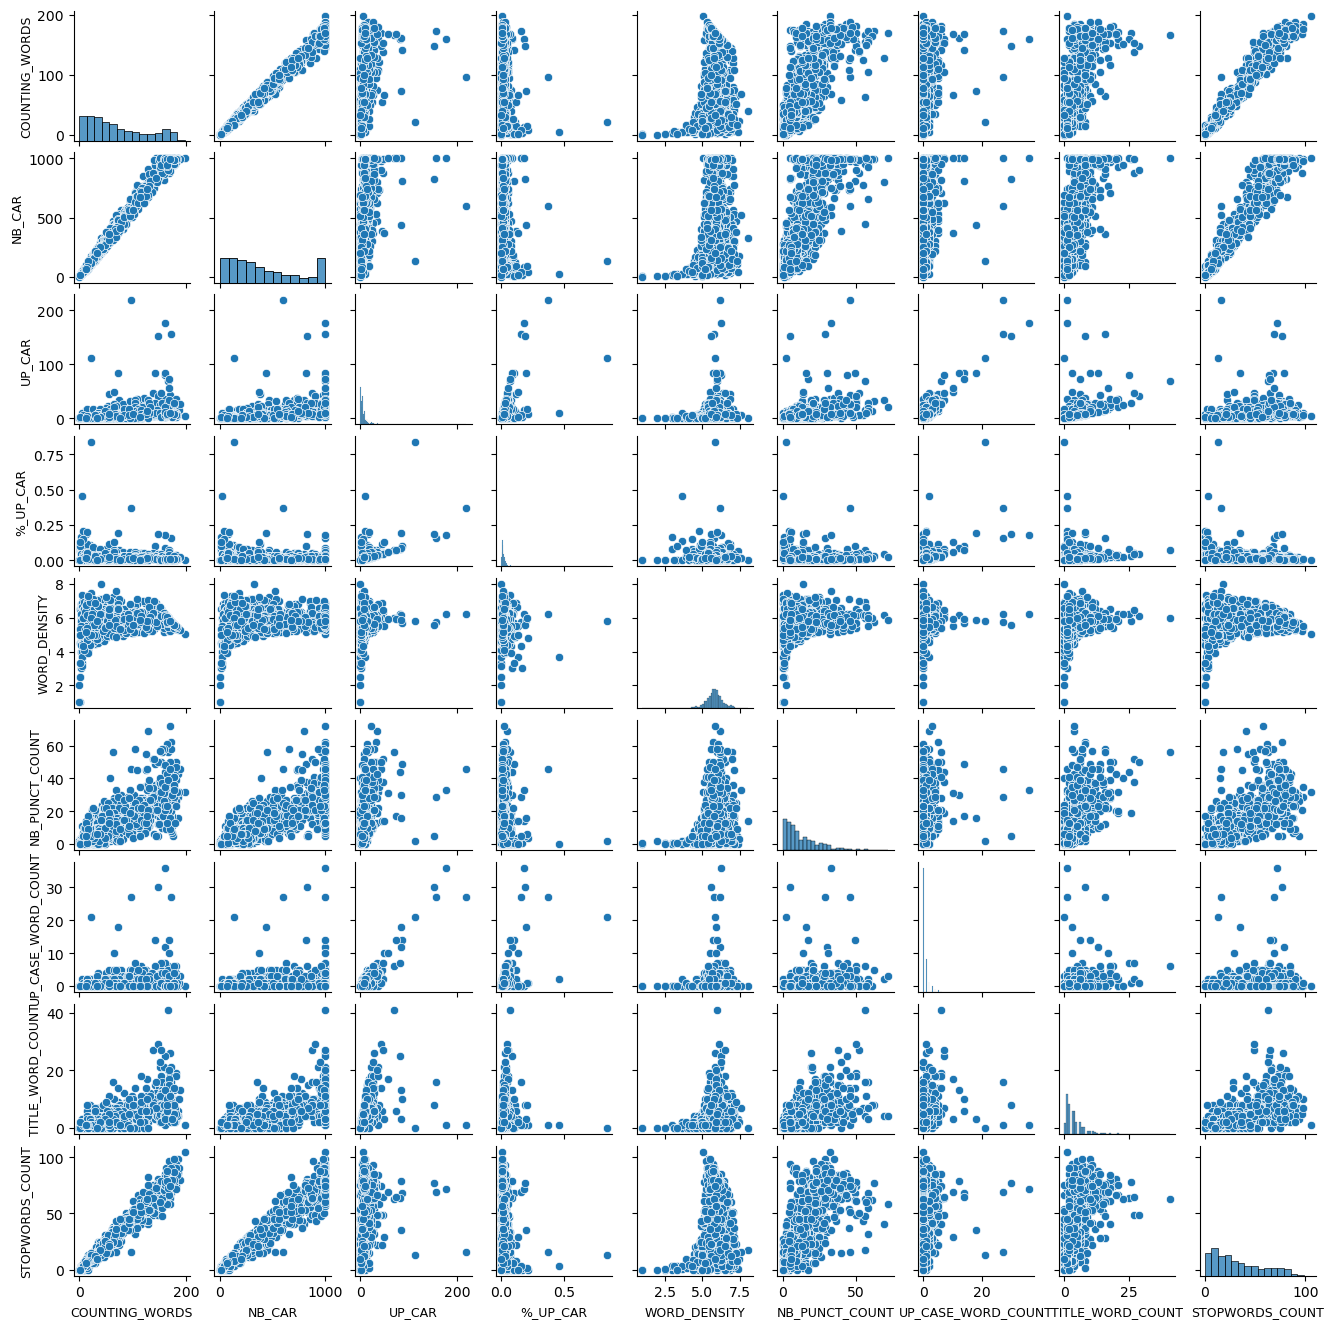

In [21]:
plt.rcParams["axes.labelsize"] = 9
pairwise_data = mod_data[['COUNTING_WORDS','NB_CAR','UP_CAR','%_UP_CAR','WORD_DENSITY','NB_PUNCT_COUNT','UP_CASE_WORD_COUNT',
                   'TITLE_WORD_COUNT','STOPWORDS_COUNT']]
sns.pairplot(pairwise_data, height = 1.5)

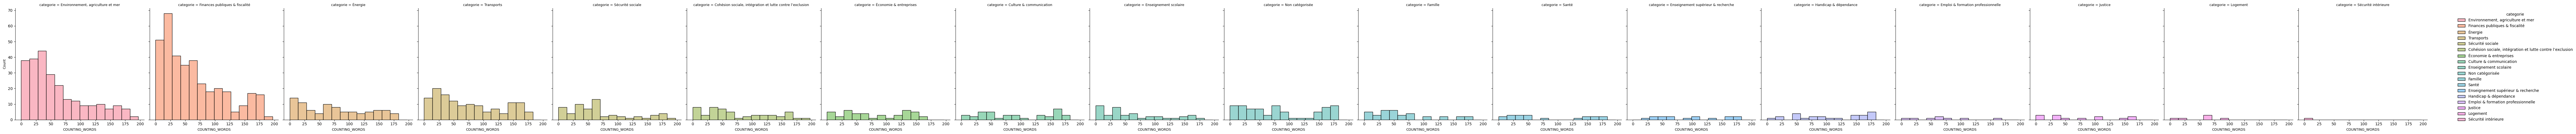

In [22]:
sns.displot(data = mod_data, x = "COUNTING_WORDS", col = "categorie", hue = "categorie")

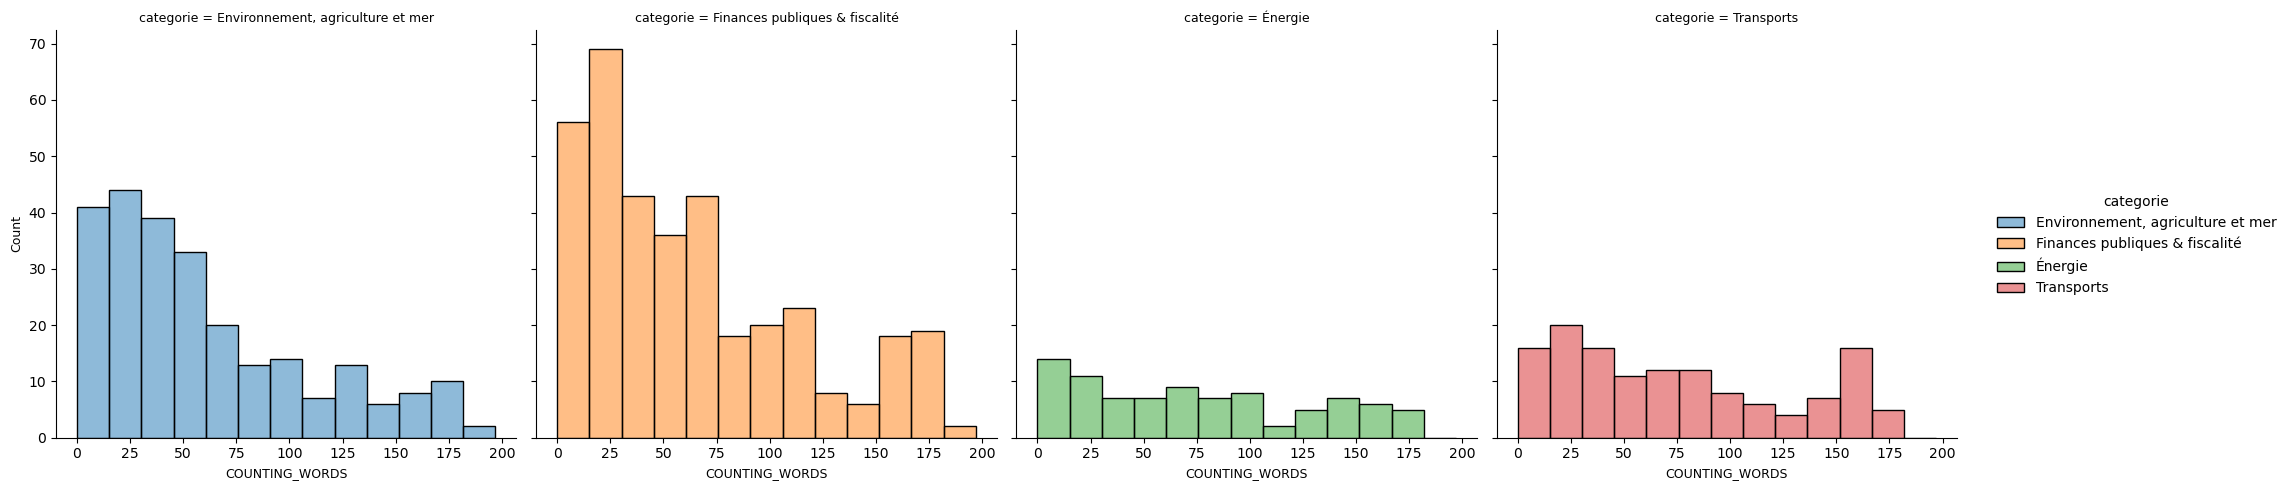

In [23]:
fitered_data = mod_data[(mod_data['categorie'] == "Finances publiques & fiscalité")|(mod_data['categorie'] == "Environnement, agriculture et mer")|
                        (mod_data['categorie'] == "Transports")|(mod_data['categorie'] == "Énergie")]
sns.displot(data = fitered_data, x = "COUNTING_WORDS", col = "categorie", hue = "categorie")

In [24]:
fitered_data 

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires,COUNTING_WORDS,NB_CAR,WORD_DENSITY,UP_CAR,%_UP_CAR,NB_PUNCT_COUNT,TITLE_WORD_COUNT,UP_CASE_WORD_COUNT,STOPWORDS_COUNT,URL
0,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Je partage ce point et ici on ne parle que d'u...,54,283,5.145455,2,0.007117,6,2,1,30,False
1,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Préservons la mer qui loin de toute surveillan...,16,103,6.058824,1,0.009709,0,1,0,8,False
2,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Que l'on arrête de nous mentir !! La protectio...,21,110,5.000000,3,0.027273,4,3,0,12,False
3,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",La protection des océans doit être notre prior...,9,58,5.800000,1,0.017241,1,1,0,5,False
4,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Il faut protéger tout ce que la terre et les o...,51,311,5.980769,1,0.003215,1,2,1,24,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1336,Redistribution et répartition de la taxe d’amé...,je suggère une enquête sur l’usage et la répar...,1,2,3,Finances publiques & fiscalité,Le fléchage vers les ENS de la taxe d'aménagem...,14,81,5.400000,4,0.049383,1,1,1,7,False
1337,Collectivités ultramarines et décentralisation,Faut-il revenir sur la décentralisation des co...,1,2,2,Finances publiques & fiscalité,"Je pense que, à part La Réunion-Mayotte, les c...",30,214,6.903226,7,0.032710,6,6,1,12,False
1338,Financer les retraites par la réforme des succ...,La réforme de la fiscalité des successions et ...,1,2,3,Finances publiques & fiscalité,Je transfère ici un commentaire publié sous la...,169,992,5.835294,10,0.010111,46,11,0,74,False
1361,Réduction du coût moyen et augmentation de la ...,Objectifs (financiers et sociaux):Amelioration...,2,1,2,Finances publiques & fiscalité,Sur le dernier point je ne pense pas que le bu...,125,685,5.436508,9,0.013139,13,6,2,61,False


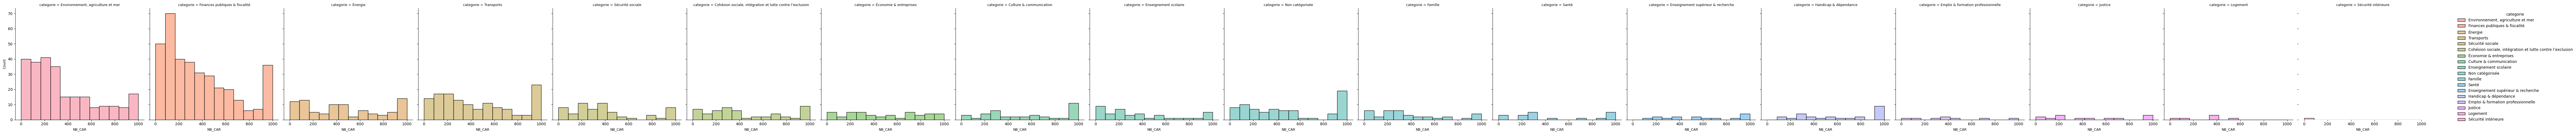

In [25]:
sns.displot(data = mod_data, x = "NB_CAR", col = "categorie", hue = "categorie")
plt.box(False)

 ### Text mining (nlp light)

In [26]:
## ajoute un espace après un point ou une virgule (correction erreur de frappe)
def correct(text):
    new = re.sub(r'[\.](?!\r)', '. ', re.sub(r' +', ' ', text))  
    new = re.sub(r'[,](?!\r)', ', ', re.sub(r' +', ' ', text))  
    return new

## tokenization( à choisir parmi les deux)
def tokenizer_wp(text):
    tokenizer = WordPunctTokenizer()
    return (tokenizer.tokenize(text))

def spacy_tokenizer(doc):
    return [x.orth_ for x in nlp_fr(doc)]

# suppression des stopwords
def remove_stop_words(tokens):
    return [t for t in tokens if str(t).lower() not in STOP_WORDS]

## orchestration pipeline de transformation
""" 
    - définition du pipeline càd les étapes du pipeline : 
     passage dans l'ordre des fonctions :lowercase, tokenisation et suppression des mots communs
    - application du pipeline aux textes à l'aide de la fonction 'prepare'
    
"""
pipeline = [str.lower, tokenizer_wp, remove_stop_words]

def prepare(text, pipeline):
    texts = text
    for transforms in pipeline:
        texts = transforms(texts)
    return texts

In [27]:
## Préparation du corpus
"""
Trois étapes: 
 - passage de différentes étapes afin de nettoyer le texte
 - suppression des mots communs
 - tokenisation du texte
"""

# étape 1
def clean_string(text, stem = "None"):

    # mise en minuscule du texte
    text = text.lower()
    # normalisation double lettre
    text = re.sub(r'([a-z])\1{2,}', r'\1', text) 
    #text = re.sub(r'\d', lambda x: correct[x.group()], text)
    # ajoute un espace après un point ou une virgule (correction erreur de frappe)
    # supprime les urls
    text = re.sub('@(\w+)| http\S+\s*',' ', text) 
    # supprime les urls http https
    text = re.sub('http\S+\s*', ' ', text) 
    # supprimme les adresses mails
    text = re.sub('\S*@\S*\s?','',  text)
    # supprimme chiffres
    text = re.sub(r'\d+', '', text) 
    # supprimme mots comprenant à la fois lettres et chiffres
    text = re.sub('\w*\d\w*', '', text) 
    # suppression des extra-espaces
    text = re.sub(r'^\s+|\s+?$', '', text) 
    # suppression des mots infèrieurs à 3 caractères
    text = re.sub(r'\b\w{1,2}\b', '', text) 
    # suppression de tous les caractères spéciaux sauf caractères accentués
    text = re.sub(r'[^ \nA-Za-z0-9À-ÖØ-öø-ÿЀ-ӿ/]+', '', text)
    # supprimme espace devant le texte
    text = re.sub(r"^\s+", "", text)
    # supprimme extra spaces (cleanage final
    text = re.sub(r'\s+', ' ', text)    
    
    return text

mod_data['commentaires_clean'] = mod_data['commentaires'].apply(lambda x: clean_string(x))

## étape 2 : suppression des mots communs
mod_data['commentaires_clean']  = mod_data['commentaires_clean'].apply(lambda x: ' '.join([item for item in x.split() if item not in STOP_WORDS])) # suppression des stopwords

## étape 3: tokenisation 
### application du pipeline de traitemment au corpus
mod_data['unigrams'] = mod_data['commentaires_clean'].apply(prepare, pipeline = pipeline)

 ### Visualisation des mots les plus présents après préparation du texte

In [28]:
# extraction des tokens et ranking
#df = mod_data['commentaires_clean'].value_counts().reset_index(name = 'volume').set_axis(['word','volume'], axis = 1) 
# a réécrire sous la forme d'une fonction 
tableau_token = mod_data.explode('unigrams')
tableau_token = tableau_token [["unigrams"]]
volume = tableau_token ['unigrams'].value_counts()
volume = pd.DataFrame(data = volume)
volume['words'] = volume.index
volume.columns = ['volume','word'] 
volume = volume[['volume', 'word']]
volume['word'] =  volume ['word'].astype('string')

#filtrage sur les 50 premiers tokens les plus présents en volume
N = 50
df = volume.sort_values(by = "volume", ascending = False).head(N)
df

,volume,word
bien,219,bien
faire,213,faire
argent,206,argent
non,182,non
public,181,public
comptes,161,comptes
faut,141,faut
/,131,/
cour,127,cour
france,121,france


In [29]:
bars = alt.Chart(df).mark_bar(color = '#335DFF', size = 9).encode(
   alt.X('volume:Q'),
   alt.Y('word', sort = alt.EncodingSortField(field = "comptes", op = "count",
                                            order = 'ascending'))
).properties(height = 500, width = 1000, 
             title = "TOP 50 des mots les plus présents au sein des commentaires après filtrage des mots communs")
bars

/opt/anaconda3/lib/python3.8/site-packages/altair/utils/core.py:317: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for col_name, dtype in df.dtypes.iteritems():


alt.Chart(...)

Commentaires: 
- argent et public sont les mots les plus présents du dataset
- la présence des éléments "chasse" et "chasseurs" est suprenant

In [30]:
# test sur les textes contiennent des urls
url_regex = r'[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)'
mod_data['URL'] = mod_data['commentaires'].str.contains(url_regex, regex = True)

/var/folders/7x/vm8qf_01403bxnxfwnsjwjfr0000gn/T/ipykernel_1423/4249750566.py:3: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  mod_data['URL'] = mod_data['commentaires'].str.contains(url_regex, regex = True)


In [31]:
mod_data[mod_data['URL'] == True]

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires,COUNTING_WORDS,NB_CAR,WORD_DENSITY,UP_CAR,%_UP_CAR,NB_PUNCT_COUNT,TITLE_WORD_COUNT,UP_CASE_WORD_COUNT,STOPWORDS_COUNT,URL,commentaires_clean,unigrams
33,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer","Ne jamais rien lâcher, pour que la vérité soit...",24,144,5.760000,2,0.013986,9,2,0,10,True,jamais rien lâcher vérité actions entreprises ...,"[jamais, rien, lâcher, vérité, actions, entrep..."
81,Enquêter sur les moyens humains et financiers ...,À l’heure du réchauffement climatique débridé ...,97,1825,260,"Environnement, agriculture et mer",Qui sera parmi vous au Sommet mondial de l'Océ...,75,468,6.157895,35,0.074946,19,6,5,22,True,sommet mondial océan fin juin/début juillet li...,"[sommet, mondial, océan, fin, juin, /, début, ..."
100,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Et on s’étonne que le citoyen n’ai plus confia...,30,168,5.419355,7,0.041667,5,2,0,10,True,étonne citoyen confianceelle energie démesurée...,"[étonne, citoyen, confianceelle, energie, déme..."
107,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,...Tant que nos élus écouteront les lobbies qu...,65,398,6.030303,3,0.007538,14,3,0,31,True,élus écouteront lobbies beaucoup pouvoir simpl...,"[élus, écouteront, lobbies, beaucoup, pouvoir,..."
188,L'argent public destiné aux fédérations de cha...,"Chaque année en France, des millions d'euros d...",114,1164,271,"Environnement, agriculture et mer","Pour préserver la faune sauvage, mieux vaut do...",81,453,5.524390,26,0.057395,20,4,2,37,True,préserver faune sauvage mieux vaut donner arge...,"[préserver, faune, sauvage, mieux, vaut, donne..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1297,Economies sur la prise en charge des traitemen...,Que concerne mon sujet ?La prise en charge par...,2,3,2,Non catégorisée,"Malheureusement, c'est d'abord un problème lég...",163,994,6.060976,11,0.011089,43,10,1,74,True,malheureusement problème législatif partie his...,"[malheureusement, problème, législatif, partie..."
1320,"Piloter la gestion publique, passer d'un systè...","Dans le secteur privé, tout cadre, directeur, ...",12,2,1,Non catégorisée,vous avez raison de dire que c'est compliqué m...,177,996,5.595506,4,0.004016,41,2,1,76,True,avez raison compliqué citoyen paye dirigeants ...,"[avez, raison, compliqué, citoyen, paye, dirig..."
1321,"Piloter la gestion publique, passer d'un systè...","Dans le secteur privé, tout cadre, directeur, ...",12,2,1,Non catégorisée,Raison pour laquelle je dis qu'on peut faire d...,180,993,5.486188,7,0.007056,47,5,0,72,True,raison dis faire rapports infini élaguer amazo...,"[raison, dis, faire, rapports, infini, élaguer..."
1322,"Piloter la gestion publique, passer d'un systè...","Dans le secteur privé, tout cadre, directeur, ...",12,2,1,Non catégorisée,ultime remarque managériale : il sera beaucoup...,161,999,6.166667,6,0.006012,35,3,0,75,True,ultime remarque managériale beaucoup intéressa...,"[ultime, remarque, managériale, beaucoup, inté..."


 ## Classification
Est-il possible de créer un modèle de classification automatique en catégorie des commentaires en s'appuyant sur la qualification existante sachant: 
 - volume total de commentaires est faible, 
 - déséquilibre important entre les catégories au niveau des volumes de commentaires (moins de 50 commentaires pour la moitié des catégories)
 
En dépit de ces obstacles, construction d'un modèle de classification automatique en mobilisant les algorithmes traditionnels du ML (hors deep learning). 

In [32]:
filtered_mod_data = pd.DataFrame(mod_data.categorie.value_counts().reset_index().values, columns = ["categorie", "volume"])
filtered_mod_data = filtered_mod_data[filtered_mod_data['volume'] >= 50]
right_join_df = pd.merge(mod_data, filtered_mod_data, on = 'categorie', how = 'right')
right_join_df 

,titre,corps,nombre_de_commentaires,nombre_de_soutiens,nombre_abonnements,categorie,commentaires,COUNTING_WORDS,NB_CAR,WORD_DENSITY,UP_CAR,%_UP_CAR,NB_PUNCT_COUNT,TITLE_WORD_COUNT,UP_CASE_WORD_COUNT,STOPWORDS_COUNT,URL,commentaires_clean,unigrams,volume
0,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Les citoyen ont le droit de savoir. Ces obsta...,11,69,5.750000,2,0.029412,2,2,0,6,False,citoyen droit savoir obstacle inadmissible,"[citoyen, droit, savoir, obstacle, inadmissible]",361
1,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,"Quand on a rien à se reprocher, on a rien à ca...",12,51,3.923077,1,0.019608,2,1,0,8,False,rien reprocher rien cacher,"[rien, reprocher, rien, cacher]",361
2,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Honte absolue de l'administration qui refuse d...,19,116,5.800000,1,0.008621,3,1,0,6,False,honte absolue administration refuse appliquer ...,"[honte, absolue, administration, refuse, appli...",361
3,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Et on s’étonne que le citoyen n’ai plus confia...,30,168,5.419355,7,0.041667,5,2,0,10,True,étonne citoyen confianceelle energie démesurée...,"[étonne, citoyen, confianceelle, energie, déme...",361
4,Enquêter sur l’administration des données de s...,Après avoir épuisé tous les recours pour obten...,90,1293,231,Finances publiques & fiscalité,Merci à Claire et son équipe pour leur combat....,31,174,5.437500,4,0.022989,4,4,0,18,False,claire équipe combat honte gouvernants conduis...,"[claire, équipe, combat, honte, gouvernants, c...",361
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1014,La retraite automatique par les organismes,Je ne comprends pas qu'il faille préparer son ...,7,3,2,"Cohésion sociale, intégration et lutte contre ...","Oui, ce chiffre de 'Non Recours au droit' dev...",168,998,5.905325,35,0.035211,43,20,3,66,False,oui chiffre non recours droit devrait figurer ...,"[oui, chiffre, non, recours, droit, devrait, f...",52
1015,La retraite automatique par les organismes,Je ne comprends pas qu'il faille préparer son ...,7,3,2,"Cohésion sociale, intégration et lutte contre ...","De plus , savez vous que toutes les caisses ve...",177,999,5.612360,28,0.028169,29,6,4,85,False,savez caisses versent montants dates constitut...,"[savez, caisses, versent, montants, dates, con...",52
1016,La retraite automatique par les organismes,Je ne comprends pas qu'il faille préparer son ...,7,3,2,"Cohésion sociale, intégration et lutte contre ...",Je ne comprends pas pourquoi ce n'est pas la m...,68,337,4.884058,2,0.005952,8,2,0,43,False,comprends chose monde père joué partie chanteu...,"[comprends, chose, monde, père, joué, partie, ...",52
1017,La retraite automatique par les organismes,Je ne comprends pas qu'il faille préparer son ...,7,3,2,"Cohésion sociale, intégration et lutte contre ...","L""argent des retraites est aussi versée à des ...",48,265,5.408163,4,0.015209,4,3,1,26,False,argent retraites versée étrangers deviennent c...,"[argent, retraites, versée, étrangers, devienn...",52


In [33]:
from sklearn import set_config

set_config(display="diagram")

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.pipeline import Pipeline
from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import average_precision_score

import matplotlib.pyplot as plt
from matplotlib import pyplot


from pprint import pprint
from time import time
import logging

ImportError: cannot import name 'set_config' from 'sklearn' (unknown location)

In [ ]:
seed = 42
X = right_join_df['commentaires_clean'].values
y = right_join_df['categorie'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, 
                                                    random_state = seed,
                                                    stratify = y)

pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol = 1e-3)), # choix de l'algorithme de classification SGDC (Stochastic Gradient Descent - Classifier)
])

# SGDC: linear classifier (SVM, logistic regression, a.o.) optimized by the SGD (used to minimize a cost function)
# https://michael-fuchs-python.netlify.app/2019/11/11/introduction-to-sgd-classifier/
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0), # seuil pour supprimmer un mot en fonction
    # du pourcentage d'occurence de celui-ci dans l'ensemble des documents ex: si 8 fois sur 10 documents avec seuil de 0.75 --> suppression
    # vect__min_df suppression si le mot est inférieur à une certaine fréquence
     'vect__max_features': (5000, 10000, 50000), # longueur du vocabulaire n mots les plus fréquents
    'vect__ngram_range': ((1, 1), (1, 2), (1, 3)),  # unigrams, bigrams ou trigrams
     #'tfidf__use_idf': (True, False), # utilisation idf ou non
     #'tfidf__norm': ('l1', 'l2'), # normalisation tf_idf
    'clf__alpha': (0.0001, 0.00001), # regularisation (plus alpha est grand, moins est imprtante la regularisation)
    'clf__penalty': ('l2', 'elasticnet'), # type regularisation regression logistique (L2 ou mix l1 et l2)
     'clf__max_iter': (50, 100), # nombre d'iterations
}

if __name__ == "__main__":
 
    grid_search = GridSearchCV(pipeline, parameters, cv=10,
                               n_jobs=-1, verbose=3)

    print("Recherche  de la meilleure combinaision d'hyperparamètres à l'aide du grid search...")
    print("Pipeline de transformation utilisé:", [name for name, _ in pipeline.steps])
    print("Plage des hyperparamètres:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(X_train, y_train)
   
    print("calculé %0.3fs" % (time() - t0))

    print("Meilleur score: %0.3f" % grid_search.best_score_)
    print("Meilleur ensemble pour hyperparamètres:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

optimised_grid_search_light = grid_search.best_estimator_

In [ ]:
score = optimised_grid_search_light.score(X_test, y_test)
print("Exactitude globale:", score)

In [ ]:
# calcul des métriques d'évaluation du modèle

y_pred = optimised_grid_search_light.predict(X_test)
accuracy = metrics.accuracy_score(y_pred, y_test)
print("Exactitude globale du modèle: ", accuracy)

# matrice de classification
print(classification_report(y_test, y_pred))   
#print("Test F-score: ", metrics.f1_score(y_test, y_pred))

In [29]:
# utilisation de la fonction de matrice de confusion présentée dans la documentation scikit-learn
def plot_confusion_matrix(cm, classes,
                          normalize = True, # normalisation ou non
                          title = 'Matrice de confusion',
                          cmap=plt.cm.Blues):
    """
    Cette fonction imprime et trace la matrice de confusion.
    La normalisation s'effectue à partir du paramètre `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Matrice de confusion avec normalisation")
    else:
        print('Matrice de confusion sans normalisation')

    #print(cm)

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Véritable label')
    plt.xlabel('Label prédit')
    plt.tight_layout()

Matrice de confusion avec normalisation


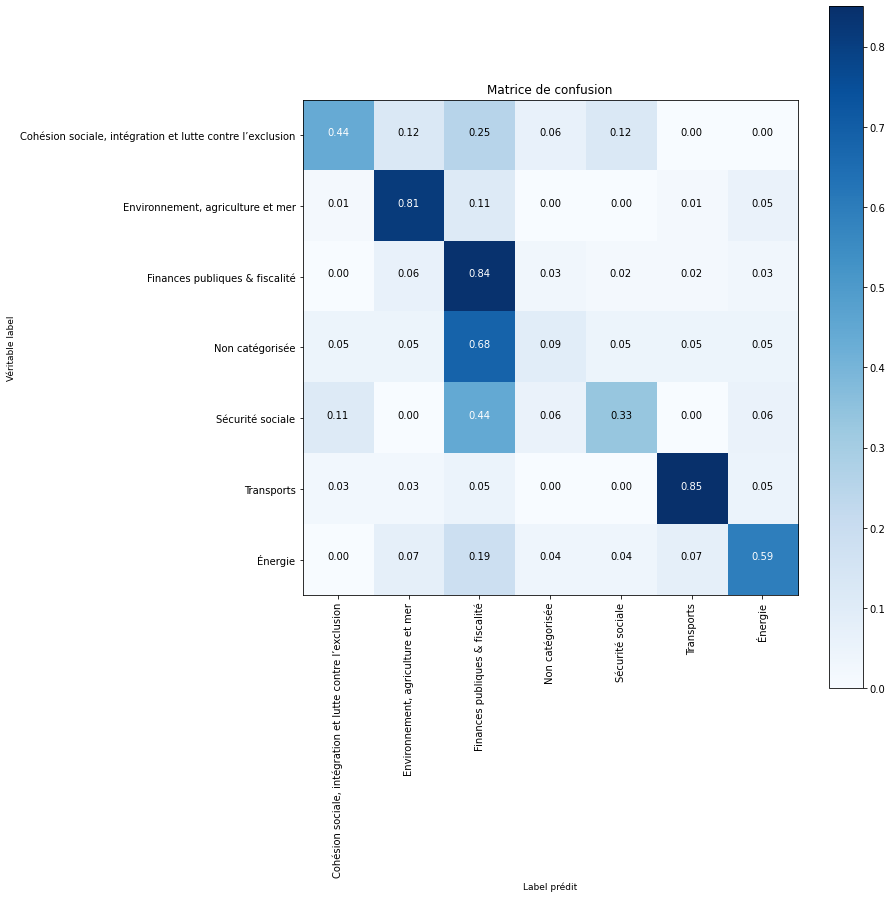

<Figure size 432x288 with 0 Axes>

In [30]:
import itertools
labels = np.unique(y_test)
confmat = metrics.confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# création
fig = plt.figure(1, figsize = (13, 13))
plot_confusion_matrix(confmat, classes = labels,
                      title = 'Matrice de confusion')

fig = plt.figure()